# Preparation of Notebook

In [1]:
!pip install transformers
!pip install tweet-preprocessor
import transformers
from transformers import *

import torch
import tensorflow as tf

from sklearn import metrics
from sklearn.model_selection import KFold

import preprocessor as p
import numpy as np
import pandas as pd
import time
import datetime
import random
import io

print('Transformers version: ', transformers.__version__)
print('Tensorflow version: ', tf.__version__)

Transformers version:  2.5.1
Tensorflow version:  1.15.0


In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


# Importing Data from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv('./drive/My Drive/GA/capstone/data/train.csv')
test_df = pd.read_csv('./drive/My Drive/GA/capstone/data/test.csv')
submissions = pd.read_csv('./drive/My Drive/GA/capstone/data/sample_submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Cleaning and Preparation

In [4]:
#dropping of duplicate tweets
train_df.drop_duplicates(subset='text',keep='last',inplace=True)
train_df.reset_index(drop=True,inplace=True)
train_df.shape

(7503, 5)

In [5]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))

# Display 5 random rows from the data.
train_df.sample(5)

Number of training sentences: 7,503



,id,keyword,location,text,target
5233,7598,pandemonium,Nigeria,Pandemonium In Aba As Woman Delivers Baby With...,1
5707,8280,rioting,"heart of darkness, unholy ?",@Georgous__ what alternatives? Legal alternati...,0
5888,8542,screams,lesa * she/her,@TromboneTristan OOOOOHSHIT OOOHSHIT SCREAMS h...,0
2653,3853,detonation,NaN,Ignition Knock (Detonation) Sensor-Senso Stand...,1
885,1290,bloody,Chicago,I can't bloody wait!! Sony Sets a Date For Ste...,0


In [0]:
#cleaning the tweets of links and twitter handles
import regex as re
p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
train_df['text']=[p.clean(x) for x in train_df['text']]
train_df['text']=[re.sub(r'(&amp;)|(&lt;)|(b&gt;)|([!?.]*[!?.])',"",x) for x in train_df['text']]

Text(0.5, 0, 'Tweet Length')

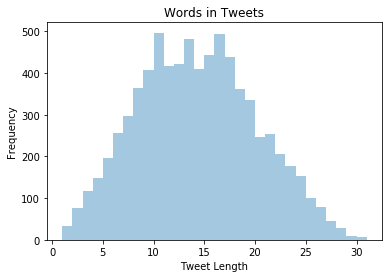

In [7]:
#plotting the distribution of tweet lengths
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

tweet_length = []
for x in train_df['text']:
    tweet_length.append(len(x.split()))
sns.distplot(tweet_length,kde=False,bins=np.arange(min(tweet_length), max(tweet_length) + 1))
plt.title('Words in Tweets')
plt.ylabel('Frequency')
plt.xlabel('Tweet Length')

# BERT Tokenization and Preparation

In [8]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

n=55
# Print the original sentence.
print(' Original: ', train_df['text'][n])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_df['text'][n]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_df['text'][n])))

Loading BERT tokenizer...
 Original:  TRUCK ABLAZE : R21 VOORTREKKER AVE OUTSIDE OR TAMBO INTL CARGO SECTION
Tokenized:  ['truck', 'ab', '##laze', ':', 'r', '##21', 'vo', '##ort', '##rek', '##ker', 'ave', 'outside', 'or', 'tam', '##bo', 'int', '##l', 'cargo', 'section']
Token IDs:  [4744, 11113, 24472, 1024, 1054, 17465, 29536, 11589, 16816, 5484, 13642, 2648, 2030, 17214, 5092, 20014, 2140, 6636, 2930]


In [9]:
train_df.text = [tokenizer.tokenize(x) for x in train_df.text]
train_df.shape

(7503, 5)

In [10]:
pd.set_option('display.max_colwidth', -1)
train_df['length'] = [len(x) for x in train_df.text]
train_df = train_df[train_df['length']<=50] #to drop the three unrelated tweets, possibly from weather stations.
train_df.reset_index(drop=True,inplace=True)
train_df.shape

(7500, 6)

In [11]:
train_df.head(2)

,id,keyword,location,text,target,length
0,1,NaN,NaN,"[our, deeds, are, the, reason, of, this, #, earthquake, may, allah, forgive, us, all]",1,14
1,4,NaN,NaN,"[forest, fire, near, la, ron, ##ge, sas, ##k, canada]",1,9


In [12]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for word in train_df['text']:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_word = tokenizer.encode(
                        word,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_word)

# Print sentence 0, now as a list of IDs.
print('Original: ', train_df['text'][117])
print('Token IDs:', input_ids[117])

Original:  ['#', 'wisdom', '##wed', 'bonus', '-', '5', 'minute', 'daily', 'habits', 'that', 'could', 'really', 'improve', 'your', 'life', 'how', 'many', 'do', 'you', 'already', 'do', '#', 'life', '##ha', '##cks']
Token IDs: [101, 1001, 9866, 15557, 6781, 1011, 1019, 3371, 3679, 14243, 2008, 2071, 2428, 5335, 2115, 2166, 2129, 2116, 2079, 2017, 2525, 2079, 1001, 2166, 3270, 10603, 102]


Text(0.5, 0, 'Number of Tokens')

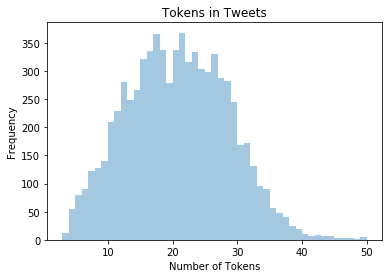

In [13]:
#plotting the distribution of token lengths
token_lengths=[len(i) for i in input_ids]
sns.distplot(token_lengths,kde=False,bins=np.arange(min(token_lengths), max(token_lengths) + 1))
plt.title('Tokens in Tweets')
plt.ylabel('Frequency')
plt.xlabel('Number of Tokens')

In [0]:
#splitting the data into X & y
tweet = train_df.text.values
labels = train_df.target.values

In [15]:
print('Max sentence length: ', max([len(i) for i in input_ids]))

Max sentence length:  50


In [16]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
MAX_LEN = 50

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 50 values...

Padding token: "[PAD]", ID: 0

Done.


Using TensorFlow backend.


In [0]:
# Create attention masks
attention_masks = []

# For each sentence...
for i in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in i]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Loading BERT model

In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification, can be increased for multi-class tasks
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )
from transformers import get_linear_schedule_with_warmup

# Number of training epochs 
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
def conf_matrix(pred,labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return confusion_matrix(labels_flat,pred_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Fine-Tuning BERT

In [24]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
  
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    211.    Elapsed: 0:00:14.
  Batch    80  of    211.    Elapsed: 0:00:28.
  Batch   120  of    211.    Elapsed: 0:00:41.
  Batch   160  of    211.    Elapsed: 0:00:55.
  Batch   200  of    211.    Elapsed: 0:01:09.

  Average training loss: 0.45
  Training epoch took: 0:01:13

Running Validation...
  Accuracy: 0.83
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    211.    Elapsed: 0:00:14.
  Batch    80  of    211.    Elapsed: 0:00:28.
  Batch   120  of    211.    Elapsed: 0:00:42.
  Batch   160  of    211.    Elapsed: 0:00:56.
  Batch   200  of    211.    Elapsed: 0:01:10.

  Average training loss: 0.32
  Training epoch took: 0:01:14

Running Validation...
  Accuracy: 0.84
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    211.    Elapsed: 0:00:14.
  Batch    80  of    211.    Elapsed: 0:00:28.
  Batch   120  of    211.    Elapsed: 0:00:43.
  

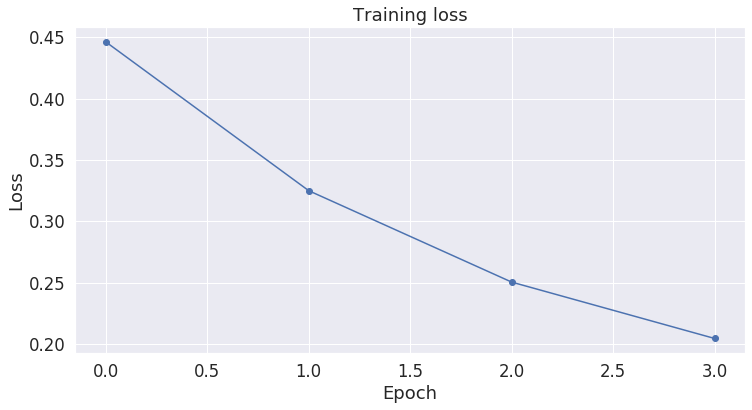

<Figure size 864x432 with 0 Axes>

In [25]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()
plt.savefig('./drive/My Drive/GA/capstone/bert_output/epoch_loss.png')

# Predicting on the test data

In [26]:
#formatting test data
test_df['text']=[p.clean(x) for x in test_df['text']]
test_df['text']=[re.sub(r'(&amp;)|(&lt;)|(b&gt;)|([!?.]*[!?.])',"",x) for x in test_df['text']]

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

# Create sentence 
test_tweet = test_df.text.values
labels = submissions.target.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for i in test_tweet:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        i,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 3,263



In [27]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [0]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
submissions.target = flat_predictions

In [0]:
submissions.to_csv('submission.csv', index = False)
!cp submission.csv "./drive/My Drive/GA/capstone"

In [0]:
test_df['target'] = flat_predictions

# Exporting the fine-tuned model

In [31]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './drive/My Drive/GA/capstone/BERT with cleaned tweets'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./drive/My Drive/GA/capstone/BERT with cleaned tweets


('./drive/My Drive/GA/capstone/BERT with cleaned tweets/vocab.txt',
 './drive/My Drive/GA/capstone/BERT with cleaned tweets/special_tokens_map.json',
 './drive/My Drive/GA/capstone/BERT with cleaned tweets/added_tokens.json')

In [32]:
!ls -l --block-size=K './drive/My Drive/GA/capstone/BERT with cleaned tweets'

total 427948K
-rw------- 1 root root      2K Mar 12 07:28 config.json
-rw------- 1 root root 427719K Mar 12 07:28 pytorch_model.bin
-rw------- 1 root root      1K Mar 12 07:28 special_tokens_map.json
-rw------- 1 root root      1K Mar 12 07:28 tokenizer_config.json
-rw------- 1 root root    227K Mar 12 07:28 vocab.txt


In [33]:
# Prediction on training set

print('Predicting labels for {:,} test sentences...'.format(len(train_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
train_predictions , train_true_labels = [], []

# Predict 
for batch in train_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  train_predictions.append(logits)
  train_true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 6,750 test sentences...
    DONE.


In [34]:
# Prediction on train-validation set

print('Predicting labels for {:,} test sentences...'.format(len(validation_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
val_predictions , val_true_labels = [], []

# Predict 
for batch in validation_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  val_predictions.append(logits)
  val_true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 750 test sentences...
    DONE.


In [0]:
train_flat_predictions = [item for sublist in train_predictions for item in sublist]
train_flat_predictions = np.argmax(train_flat_predictions, axis=1).flatten()

val_flat_predictions = [item for sublist in val_predictions for item in sublist]
val_flat_predictions = np.argmax(val_flat_predictions, axis=1).flatten()

In [0]:
def conf_unravel(true,pred):
  tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
  print("True Negatives: %s" % tn)
  print("False Positives: %s" % fp)
  print("False Negatives: %s" % fn)
  print("True Positives: %s" % tp)

  accuracy_clean = (tp + tn) / (tp + tn + fp + fn)
  print(f'Accuracy: {round(accuracy_clean,4)}')

  misclass_clean = (fp + fn) / (tp + tn + fp + fn)
  print(f'Misclassification Rate: {round(misclass_clean,4)}')

  spec_clean = tn / (tn + fp) #how many of the 'spam' was correctly classified
  print(f'Specificity: {round(spec_clean,4)}')

  sens_clean = tp / (tp + fn) #how many of the disasters was correctly identified
  print(f'Sensitivity: {round(sens_clean,4)}')

In [37]:
conf_unravel(validation_labels,val_flat_predictions)

True Negatives: 387
False Positives: 59
False Negatives: 67
True Positives: 237
Accuracy: 0.832
Misclassification Rate: 0.168
Specificity: 0.8677
Sensitivity: 0.7796


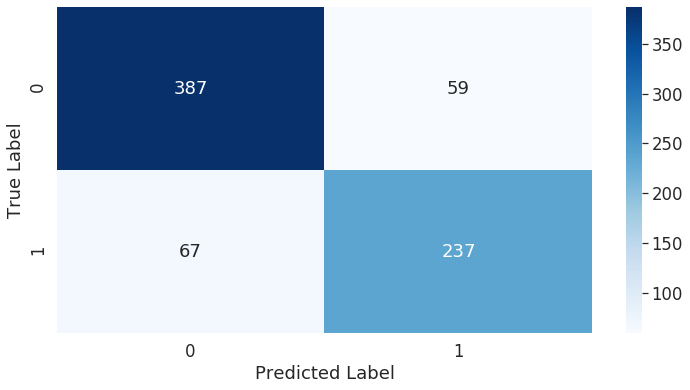

In [38]:
import seaborn as sns
sns.heatmap(confusion_matrix(validation_labels,val_flat_predictions),annot=True,fmt='g',cmap=plt.cm.Blues);
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_bert.png')